# Project Analysis: T-ECD Dataset

## 1. Project Overview
In this project, I am performing an **Exploratory Data Analysis (EDA)** on the T-ECD dataset. My goal is to demonstrate how to effectively handle and analyze large-scale transactional data systems.

### My Objectives:
1.  **Data Ingestion**: I need to programmatically download data from Hugging Face and handle the Parquet file format efficiently.
2.  **Data Modeling**: I am separating my analysis into **Static Entities** (like Users and Brands) and **Dynamic Events** (like Transactions) to mirror a real-world data warehouse schema.
3.  **Handling Big Data**: Since the full dataset is too large for memory, I am implementing strategies like partitioning and sampling to make the analysis feasible on a single machine.
4.  **Quality Assurance**: I am using statistical profiling to verify the integrity of the data before using it in downstream models.

### Context
The **T-ECD (Transactional E-Commerce Dataset)** is distributed across many partition files. I wrote this notebook to stitch these partitions together and extract meaningful insights.

In [1]:
# Install necessary libraries
# !pip install huggingface_hub pandas pyarrow ipywidgets matplotlib seaborn

## Authentication
You need a Hugging Face token to access the dataset. 
1. Go to https://huggingface.co/settings/tokens
2. Create a new token (Read access is sufficient)
3. Paste it below when prompted.

In [2]:
from huggingface_hub import login

# login()

## Configuration & Helper Functions

We define global constants to control the data loading process.

In [3]:
from huggingface_hub import hf_hub_download, list_repo_files
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# --- CONFIGURATION ---
REPO_ID = "t-tech/T-ECD"
REPO_TYPE = "dataset"
CACHE_DIR = "dataset_cache"  # Local folder to store downloaded files

# Dataset Paths
DATASET_PATH_SMALL = "dataset/small"
DATASET_PATH_FULL = "dataset/full" # Used for missing payments data

# GLOBAL CONSTANT: How many partitions to load for split datasets (e.g., events)
# Set this to a higher number (e.g., 50 or 100) to analyze more data.
# Set to None to load ALL available partitions (Warning: May run out of RAM in Colab)
DATASET_SMALL_NUM_PARTITIONS_TO_LOAD = 5 
DATASET_FULL_NUM_PARTITIONS_TO_LOAD = 1

def load_remote_parquet(filename, columns_to_exclude=None):
    """
    I use this function to download and load a specific Parquet file.
    
    Implementation Detail:
    - I implemented a check for the local cache first. If the file exists, I skip the download to save time.
    - I chose Parquet because it's column-oriented, which is much faster for the type of analytical queries I'm running compared to CSV.
    """
    print(f"Downloading {filename} to {CACHE_DIR}...")
    try:
        local_path = hf_hub_download(
            repo_id=REPO_ID,
            filename=filename,
            repo_type=REPO_TYPE,
            local_dir=CACHE_DIR,
            local_dir_use_symlinks=False
        )
        # print(f"File cached at: {local_path}")

        if columns_to_exclude:
            import pyarrow.parquet as pq
            # Read schema using read_schema (more reliable than ParquetFile)
            schema = pq.read_schema(local_path)
            # Filter out internal pyarrow columns (those starting with __)
            all_cols = [name for name in schema.names if not name.startswith('__')]
            use_cols = [c for c in all_cols if c not in columns_to_exclude]
            print(f"  Excluding columns: {columns_to_exclude}")
            print(f"  Reading columns: {use_cols}")
            df = pd.read_parquet(local_path, columns=use_cols)
            return df
        
        df = pd.read_parquet(local_path)
        return df
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return None

def load_dataframe_from_partitions(file_list, limit=DATASET_SMALL_NUM_PARTITIONS_TO_LOAD, columns_to_exclude=None):
    """
    This function handles the complexity of stitching together multiple partition files.
    
    Implementation Detail:
    - The data is split into many small files. I iterate through them, load them individually, and then concatenate them into one DataFrame.
    - I added the `limit` parameter so I can easily control how much data I load during development without changing the code logic.
    """
    if not file_list:
        print("No files provided to load.")
        return None
    
    # Sort files to ensure order (e.g., by date)
    sorted_files = sorted(file_list)
    
    # Apply limit
    if limit is not None:
        files_to_load = sorted_files[:limit]
        print(f"Loading {len(files_to_load)} partitions (out of {len(sorted_files)} available)...")
    else:
        files_to_load = sorted_files
        print(f"Loading ALL {len(files_to_load)} partitions...")

    dfs = []
    for f in files_to_load:
        df = load_remote_parquet(f, columns_to_exclude=columns_to_exclude)
        if df is not None:
            dfs.append(df)
    
    if not dfs:
        return None
    
    print("Concatenating partitions...")
    full_df = pd.concat(dfs, ignore_index=True)
    return full_df

def analyze_dataframe(df, name="DataFrame"):
    """
    I created this helper function to standardize my EDA process.
    
    For every dataset I load, I automatically run these checks:
    1.  **Shape**: To see how much data I actually have.
    2.  **Types**: To ensure IDs are strings and metrics are numbers.
    3.  **Missing Values**: To spot data quality issues immediately.
    4.  **Duplicates**: To ensure I don't have redundant records (though I skip this for massive tables to save time).
    5.  **Visualizations**: I plot distributions to understand the data's 'shape' at a glance.
    """
    if df is None:
        print(f"{name} is None, skipping analysis.")
        return

    print(f"\n" + "="*20 + f" ANALYZING: {name} " + "="*20)
    print(f"Shape: {df.shape}")
    
    print("\n1. Head (First 5 rows):")
    display(df.head())
    
    print("\n2. Info (Data Types & Non-Null Counts):")
    df.info()
    
    print("\n3. Describe (Statistical Summary for Numeric Columns):")
    display(df.describe())
    
    print("\n4. Missing Values (NaN Count):")
    missing_counts = df.isnull().sum()
    missing_pcts = df.isnull().mean() * 100
    print(missing_counts)
    print("\nMissing Percentages:")
    print(missing_pcts.round(1).astype(str) + "%")
    
    print("\n5. Duplicates Count:")
    try:
        print(df.duplicated().sum())
    except TypeError:
        print("  Warning: Unable to check for duplicates due to unhashable types (e.g., embeddings).")
        if 'embedding' in df.columns:
            print("  Retrying without 'embedding' column:")
            print(f"  {df.drop(columns=['embedding']).duplicated().sum()}")
        
    print("\n6. Column Value Counts (Top 5 unique values for object columns):")
    cat_cols = df.select_dtypes(include=['object', 'category', 'string']).columns
    for col in cat_cols:
        if col == "embedding":
            print(f"  Skipping value counts for '{col}' column (performance optimization).")
            continue
        print(f"\nColumn: {col}")
        print(df[col].value_counts().head())

    print("\n7. Visualizations:")

    # Numeric Distributions & Timedelta
    num_cols = df.select_dtypes(include=['number', 'timedelta']).columns
    if len(num_cols) > 0:
        print(f"  - Plotting distributions for numeric/timedelta columns: {list(num_cols)}")
        for col in num_cols:
            # Skip specific columns that cause issues or are not useful distributions
            if "id" in col.lower() and df[col].nunique() > 1000:
                 print(f"    Skipping distribution plot for {col} (likely an ID with high cardinality).")
                 continue
            
            plt.figure(figsize=(8, 4))
            series_to_plot = df[col].dropna()
            
            # Handle timedelta: Convert to total seconds
            if pd.api.types.is_timedelta64_dtype(series_to_plot):
                print(f"    Converting {col} to total seconds for plotting.")
                series_to_plot = series_to_plot.dt.total_seconds()
            
            sns.histplot(series_to_plot, kde=False, bins=30)
            plt.title(f"Distribution of {col}")
            plt.xlabel(col)
            plt.ylabel("Frequency")
            plt.show()

    # Categorical Counts (Top 10)
    if len(cat_cols) > 0:
        print(f"  - Plotting counts for categorical columns: {list(cat_cols)}")
        for col in cat_cols:
            if col == "embedding":
                continue # Skip embedding plots
            if df[col].nunique() > 50: # Skip if too many unique values
                print(f"    Skipping plot for {col} (too many unique values: {df[col].nunique()})")
                continue
            plt.figure(figsize=(10, 5))
            # Use full dataframe for determining the top 10 order to be accurate
            top_10_order = df[col].value_counts().iloc[:10].index
            sns.countplot(y=col, data=df, order=top_10_order)
            plt.title(f"Top 10 Counts for {col}")
            plt.xlabel("Count")
            plt.ylabel(col)
            plt.show()
    
    print("\n" + "="*60 + "\n")

## 1. Explore Repository & Index Files
We list all files once and categorize them to avoid repeated API calls.

In [4]:
all_files = list_repo_files(repo_id=REPO_ID, repo_type=REPO_TYPE)

# Categorize files by domain and type for easy access
dataset_files = defaultdict(list)

for f in all_files:
    if f.endswith(".pq"):
        # Example f: dataset/small/retail/events/01082.pq
        # Key: dataset/small/retail/events
        dirname = os.path.dirname(f).replace("\\", "/") # Normalize path separators
        dataset_files[dirname].append(f)

print("File Index Created. Available Directories:")
for d in sorted(dataset_files.keys()):
    count = len(dataset_files[d])
    print(f" - {d} ({count} files)")

File Index Created. Available Directories:
 - dataset/full (2 files)
 - dataset/full/marketplace (1 files)
 - dataset/full/marketplace/events (793 files)
 - dataset/full/offers (1 files)
 - dataset/full/offers/events (944 files)
 - dataset/full/payments/events (1309 files)
 - dataset/full/payments/receipts (1017 files)
 - dataset/full/retail (1 files)
 - dataset/full/retail/events (579 files)
 - dataset/full/reviews (1309 files)
 - dataset/small (2 files)
 - dataset/small/marketplace (1 files)
 - dataset/small/marketplace/events (227 files)
 - dataset/small/offers (1 files)
 - dataset/small/offers/events (227 files)
 - dataset/small/retail (1 files)
 - dataset/small/retail/events (227 files)
 - dataset/small/reviews (227 files)


## 2. Analysis of Static Entities
I am starting with the **Dimension Tables** (Users and Brands). These describe the entities in the system.
I treat these differently because they are static (don't change often) and are small enough to be stored as single files, unlike the event logs.

c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(



==================== ANALYZING: Users Data ====================
Shape: (3500000, 3)

1. Head (First 5 rows):


,user_id,socdem_cluster,region
0,77309558,21.0,2.0
1,72517894,10.0,90.0
2,86699708,9.0,9.0
3,54241043,17.0,58.0
4,23591057,17.0,4.0



2. Info (Data Types & Non-Null Counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500000 entries, 0 to 3499999
Data columns (total 3 columns):
 #   Column          Dtype  
---  ------          -----  
 0   user_id         uint64 
 1   socdem_cluster  float64
 2   region          float64
dtypes: float64(2), uint64(1)
memory usage: 80.1 MB

3. Describe (Statistical Summary for Numeric Columns):


,user_id,socdem_cluster,region
count,3.500000e+06,3.494847e+06,3.441083e+06
mean,4.497132e+07,1.281904e+01,4.044861e+01
std,2.596685e+07,6.463649e+00,2.927570e+01
min,3.000000e+00,0.000000e+00,0.000000e+00
25%,2.249775e+07,9.000000e+00,1.500000e+01
50%,4.496408e+07,1.200000e+01,3.700000e+01
75%,6.746539e+07,1.900000e+01,6.300000e+01
max,8.991871e+07,2.100000e+01,9.000000e+01



4. Missing Values (NaN Count):
user_id               0
socdem_cluster     5153
region            58917
dtype: int64

Missing Percentages:
user_id           0.0%
socdem_cluster    0.1%
region            1.7%
dtype: object

5. Duplicates Count:
0

6. Column Value Counts (Top 5 unique values for object columns):

7. Visualizations:
  - Plotting distributions for numeric/timedelta columns: ['user_id', 'socdem_cluster', 'region']
    Skipping distribution plot for user_id (likely an ID with high cardinality).


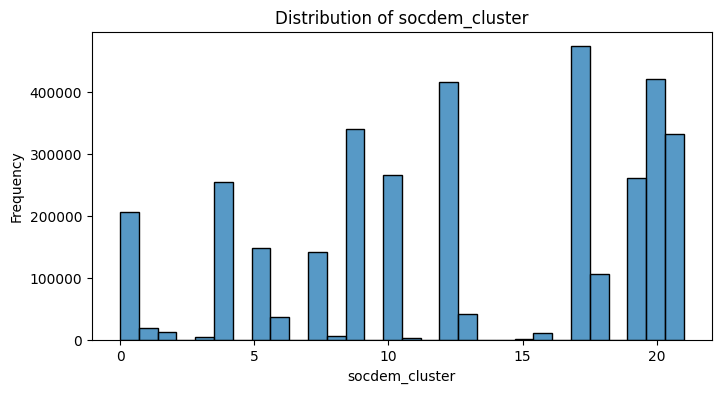

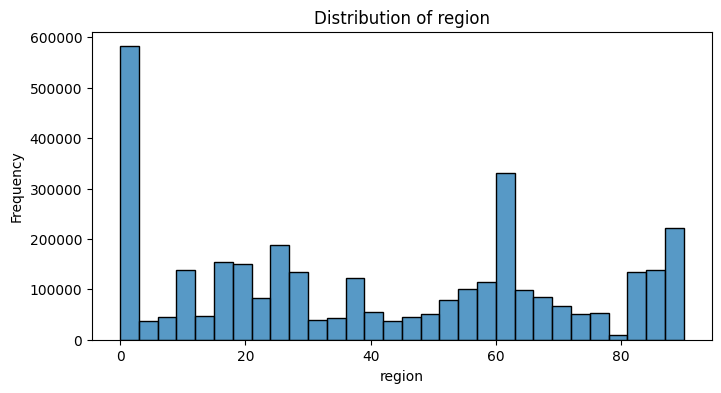

In [5]:
# --- USERS ---
users_path = f"{DATASET_PATH_SMALL}/users.pq"
df_users = load_remote_parquet(users_path)
analyze_dataframe(df_users, "Users Data")

In [6]:
# --- BRANDS ---
brands_path = f"{DATASET_PATH_SMALL}/brands.pq"
df_brands = load_remote_parquet(brands_path)

# Handle broken brands file (empty embeddings)
if df_brands is None:
    print("Attempting to load Brands without 'embedding' column due to schema error...")
    local_path = f"{CACHE_DIR}/{brands_path}"
    if os.path.exists(local_path):
        try:
            df_brands = pd.read_parquet(local_path, columns=['brand_id'])
            print("Successfully loaded Brands data (excluding embeddings).")
        except Exception as e:
            print(f"Fallback load failed: {e}")

analyze_dataframe(df_brands, "Brands Data")

c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


Error loading dataset/small/brands.pq: Expected all lists to be of size=300 but index 1 had size=0
Attempting to load Brands without 'embedding' column due to schema error...
Successfully loaded Brands data (excluding embeddings).

==================== ANALYZING: Brands Data ====================
Shape: (24513, 1)

1. Head (First 5 rows):


,brand_id
0,4
1,34
2,45
3,46
4,51



2. Info (Data Types & Non-Null Counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24513 entries, 0 to 24512
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   brand_id  24513 non-null  uint64
dtypes: uint64(1)
memory usage: 191.6 KB

3. Describe (Statistical Summary for Numeric Columns):


,brand_id
count,24513.000000
mean,125964.523233
std,72479.531826
min,4.000000
25%,63256.000000
50%,126363.000000
75%,188300.000000
max,251381.000000



4. Missing Values (NaN Count):
brand_id    0
dtype: int64

Missing Percentages:
brand_id    0.0%
dtype: object

5. Duplicates Count:
46

6. Column Value Counts (Top 5 unique values for object columns):

7. Visualizations:
  - Plotting distributions for numeric/timedelta columns: ['brand_id']
    Skipping distribution plot for brand_id (likely an ID with high cardinality).




## 3. Retail Domain Analysis
Now I am analyzing the Retail domain. This introduces **Fact Tables** (Events).

*   **Items**: Product details.
*   **Events**: User actions (views, purchases).

**Note on Event Data:**
The event data is partitioned by time because it is high-volume. I need to load and join these partitions to get a complete picture.

c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(



==================== ANALYZING: Retail Items ====================
Shape: (250171, 6)

1. Head (First 5 rows):


,item_id,brand_id,category,subcategory,price,embedding
0,fmcg_10,65693,Office Supplies and Educational Materials,Stationery Paper,-4.406018,"[-0.13557312, 0.049446248, -0.018282967, 0.025..."
1,fmcg_10000,146468,Cleaning Supplies and Everyday Household Items,Cleaning and Detergent Products,-4.205185,"[-0.043275375, -0.035317067, 0.0033219394, -0...."
2,fmcg_1000006,37799,None,None,-4.463660,"[-0.083411045, 0.049153276, -0.08736873, 0.075..."
3,fmcg_1000008,240838,Children's Products and Childcare Items,Food Products,-5.138377,"[-0.055184077, 0.02342301, 0.03789554, 0.11559..."
4,fmcg_1000017,240838,Foodstuffs and Beverages,Sweet Desserts and Confectionery,-3.980383,"[-0.052520722, -0.0063896044, -0.011138491, 0...."



2. Info (Data Types & Non-Null Counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250171 entries, 0 to 250170
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   item_id      250171 non-null  object 
 1   brand_id     250171 non-null  uint64 
 2   category     240586 non-null  object 
 3   subcategory  240586 non-null  object 
 4   price        223682 non-null  float64
 5   embedding    250171 non-null  object 
dtypes: float64(1), object(4), uint64(1)
memory usage: 11.5+ MB

3. Describe (Statistical Summary for Numeric Columns):


,brand_id,price
count,250171.000000,223682.000000
mean,118619.469799,-3.768593
std,83797.032762,1.324611
min,25989.000000,-10.000000
25%,37799.000000,-4.793809
50%,65693.000000,-3.875122
75%,240838.000000,-2.924246
max,240838.000000,7.740092



4. Missing Values (NaN Count):
item_id            0
brand_id           0
category        9585
subcategory     9585
price          26489
embedding          0
dtype: int64

Missing Percentages:
item_id         0.0%
brand_id        0.0%
category        3.8%
subcategory     3.8%
price          10.6%
embedding       0.0%
dtype: object

5. Duplicates Count:
  Retrying without 'embedding' column:
  0

6. Column Value Counts (Top 5 unique values for object columns):

Column: item_id
item_id
fmcg_999994     1
fmcg_10         1
fmcg_10000      1
fmcg_1000006    1
fmcg_1000008    1
Name: count, dtype: int64

Column: category
category
Foodstuffs and Beverages                                     160128
Cosmetics, Personal Care, and Health Maintenance Products     22998
Home Improvement and Countryside Retreat Essentials           17738
Children's Products and Childcare Items                        8339
Cleaning Supplies and Everyday Household Items                 7731
Name: count, dtype: int64

C

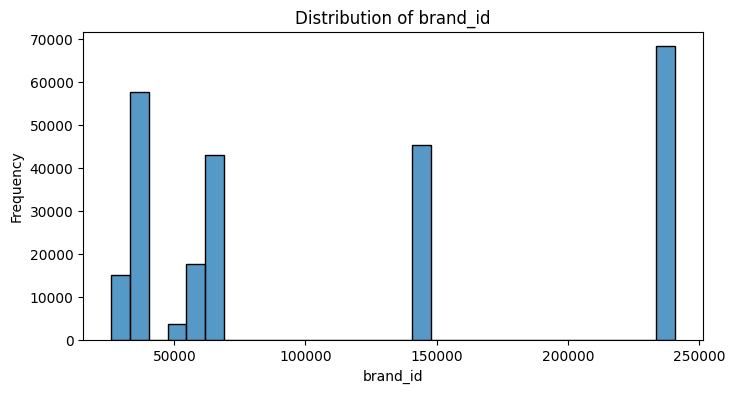

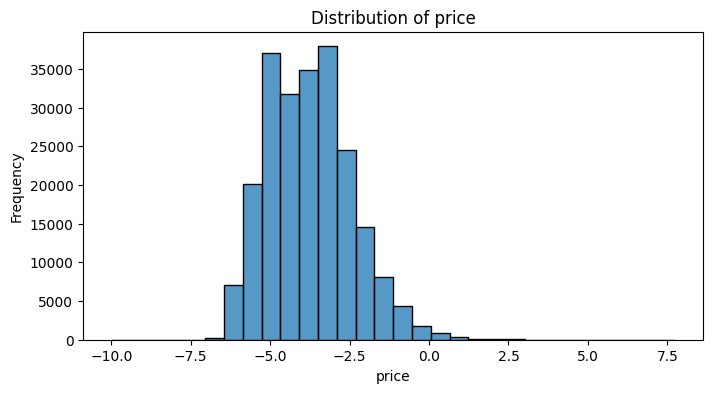

  - Plotting counts for categorical columns: ['item_id', 'category', 'subcategory', 'embedding']
    Skipping plot for item_id (too many unique values: 250171)


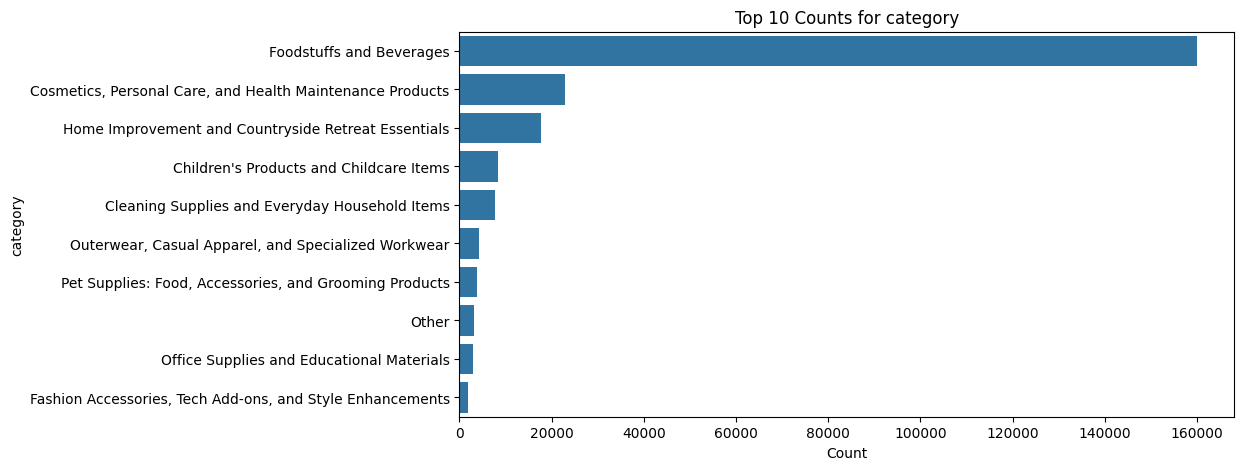

    Skipping plot for subcategory (too many unique values: 174)




In [7]:
# --- RETAIL ITEMS ---
retail_items_path = f"{DATASET_PATH_SMALL}/retail/items.pq"
df_retail_items = load_remote_parquet(retail_items_path)
analyze_dataframe(df_retail_items, "Retail Items")

Loading 5 partitions (out of 227 available)...


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


Concatenating partitions...

==================== ANALYZING: Retail Events (Joined) ====================
Shape: (1892095, 6)

1. Head (First 5 rows):


,timestamp,user_id,item_id,subdomain,action_type,os
0,1082 days 00:00:00.326593,65070494,fmcg_607128,catalog,view,android
1,1082 days 00:00:00.334152,25095614,fmcg_40462,catalog,view,android
2,1082 days 00:00:00.370722,38969384,fmcg_327866,catalog,view,android
3,1082 days 00:00:00.613473,2266567,fmcg_965886,search,view,android
4,1082 days 00:00:01.152587,25095614,fmcg_576561,catalog,view,android



2. Info (Data Types & Non-Null Counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1892095 entries, 0 to 1892094
Data columns (total 6 columns):
 #   Column       Dtype          
---  ------       -----          
 0   timestamp    timedelta64[us]
 1   user_id      uint64         
 2   item_id      object         
 3   subdomain    object         
 4   action_type  object         
 5   os           object         
dtypes: object(4), timedelta64[us](1), uint64(1)
memory usage: 86.6+ MB

3. Describe (Statistical Summary for Numeric Columns):


,timestamp,user_id
count,1892095,1.892095e+06
mean,1084 days 14:03:42.730918,4.217061e+07
std,1 days 09:33:25.871292,2.361137e+07
min,1082 days 00:00:00.326593,5.552800e+04
25%,1083 days 08:07:06.096203,2.173620e+07
50%,1084 days 21:21:44.086154,3.896938e+07
75%,1085 days 18:49:53.190578,6.083687e+07
max,1086 days 23:59:59.988044,8.991361e+07



4. Missing Values (NaN Count):
timestamp      0
user_id        0
item_id        0
subdomain      0
action_type    0
os             0
dtype: int64

Missing Percentages:
timestamp      0.0%
user_id        0.0%
item_id        0.0%
subdomain      0.0%
action_type    0.0%
os             0.0%
dtype: object

5. Duplicates Count:
0

6. Column Value Counts (Top 5 unique values for object columns):

Column: item_id
item_id
fmcg_922936    1324
fmcg_594395    1306
fmcg_849756    1215
fmcg_995990    1193
fmcg_775836    1135
Name: count, dtype: int64

Column: subdomain
subdomain
catalog    1735217
search      119759
main         23375
item          8424
cart          5320
Name: count, dtype: int64

Column: action_type
action_type
view             1834150
added-to-cart      35322
click              22623
Name: count, dtype: int64

Column: os
os
android    1845648
ios          46447
Name: count, dtype: int64

7. Visualizations:
  - Plotting distributions for numeric/timedelta columns: ['timestamp', '

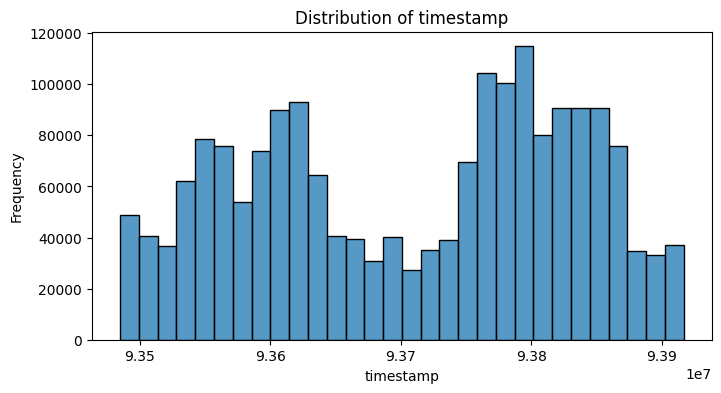

    Skipping distribution plot for user_id (likely an ID with high cardinality).
  - Plotting counts for categorical columns: ['item_id', 'subdomain', 'action_type', 'os']
    Skipping plot for item_id (too many unique values: 56454)


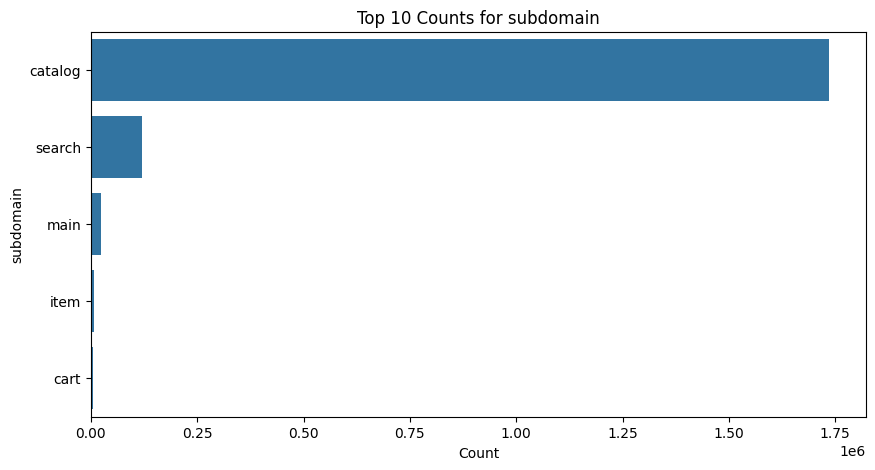

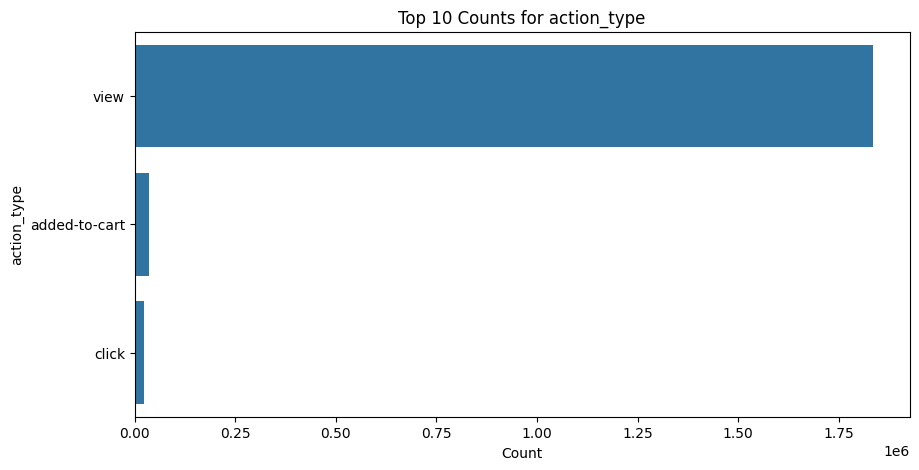

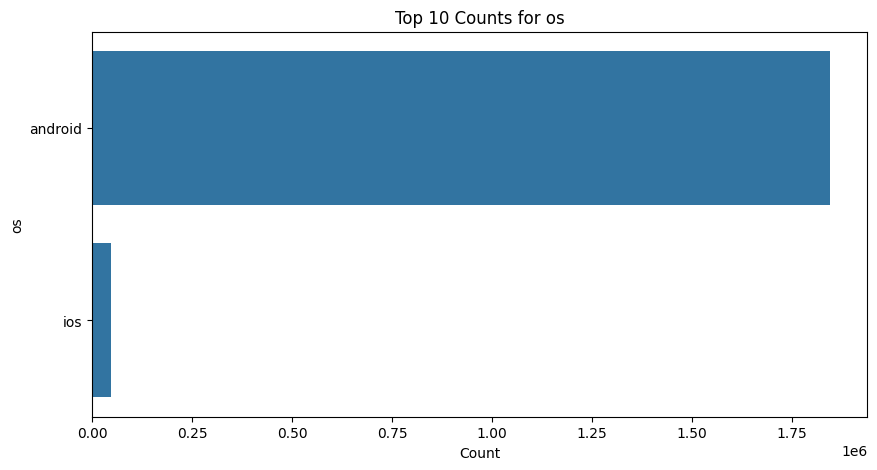

In [8]:
# --- RETAIL EVENTS ---
retail_events_dir = f"{DATASET_PATH_SMALL}/retail/events"
retail_event_files = dataset_files.get(retail_events_dir, [])

df_retail_events = load_dataframe_from_partitions(retail_event_files, limit=DATASET_SMALL_NUM_PARTITIONS_TO_LOAD)
analyze_dataframe(df_retail_events, "Retail Events (Joined)")

## 4. Marketplace Domain Analysis
Contains `items` (static) and `events` (partitioned).

In [9]:
# --- MARKETPLACE ITEMS ---
mp_items_path = f"{DATASET_PATH_SMALL}/marketplace/items.pq"
df_mp_items = load_remote_parquet(mp_items_path)
analyze_dataframe(df_mp_items, "Marketplace Items")

c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


Error loading dataset/small/marketplace/items.pq: Expected all lists to be of size=300 but index 2417 had size=0
Marketplace Items is None, skipping analysis.


Loading 5 partitions (out of 227 available)...


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


Concatenating partitions...

==================== ANALYZING: Marketplace Events (Joined) ====================
Shape: (2561575, 6)

1. Head (First 5 rows):


,timestamp,user_id,item_id,subdomain,action_type,os
0,1082 days 00:00:00.089901,59328774,nfmcg_14777696,u2i,view,android
1,1082 days 00:00:00.163483,66295302,nfmcg_26098539,catalog,view,android
2,1082 days 00:00:00.864625,37542104,nfmcg_10840247,u2i,view,android
3,1082 days 00:00:00.889192,35193548,nfmcg_8040572,catalog,view,android
4,1082 days 00:00:00.936008,27256137,nfmcg_6770239,catalog,view,android



2. Info (Data Types & Non-Null Counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2561575 entries, 0 to 2561574
Data columns (total 6 columns):
 #   Column       Dtype          
---  ------       -----          
 0   timestamp    timedelta64[us]
 1   user_id      uint64         
 2   item_id      object         
 3   subdomain    object         
 4   action_type  object         
 5   os           object         
dtypes: object(4), timedelta64[us](1), uint64(1)
memory usage: 117.3+ MB

3. Describe (Statistical Summary for Numeric Columns):


,timestamp,user_id
count,2561575,2.561575e+06
mean,1084 days 12:22:49.927225,4.524202e+07
std,1 days 10:21:25.490259,2.601577e+07
min,1082 days 00:00:00.089901,2.220000e+02
25%,1083 days 07:50:49.381045,2.258028e+07
50%,1084 days 12:10:00.701816,4.547480e+07
75%,1085 days 16:56:29.725219,6.789642e+07
max,1086 days 23:59:59.971012,8.991870e+07



4. Missing Values (NaN Count):
timestamp         0
user_id           0
item_id           0
subdomain      1115
action_type       0
os                0
dtype: int64

Missing Percentages:
timestamp      0.0%
user_id        0.0%
item_id        0.0%
subdomain      0.0%
action_type    0.0%
os             0.0%
dtype: object

5. Duplicates Count:
0

6. Column Value Counts (Top 5 unique values for object columns):

Column: item_id
item_id
nfmcg_13757063    63207
nfmcg_20114920    41663
nfmcg_5205476     33528
nfmcg_19030396    26187
nfmcg_15866681    24517
Name: count, dtype: int64

Column: subdomain
subdomain
u2i        1606753
other       429276
catalog     305216
search      189134
i2i          30081
Name: count, dtype: int64

Column: action_type
action_type
view        2471964
click         77432
clickout      11064
like           1115
Name: count, dtype: int64

Column: os
os
android    2155126
ios         404596
other         1853
Name: count, dtype: int64

7. Visualizations:
  - Plottin

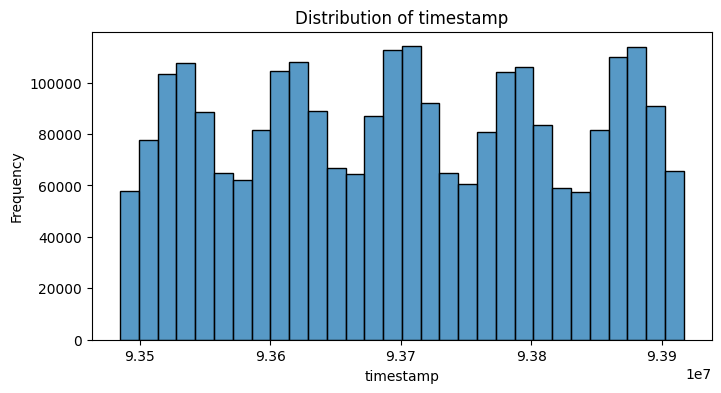

    Skipping distribution plot for user_id (likely an ID with high cardinality).
  - Plotting counts for categorical columns: ['item_id', 'subdomain', 'action_type', 'os']
    Skipping plot for item_id (too many unique values: 147148)


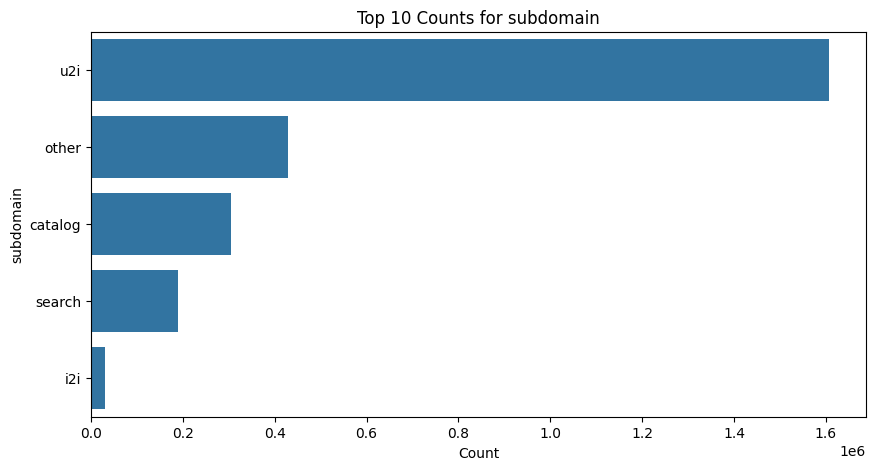

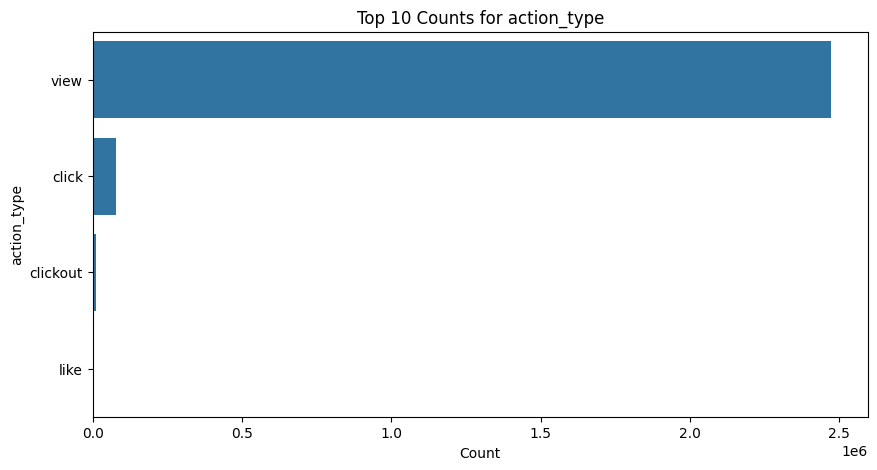

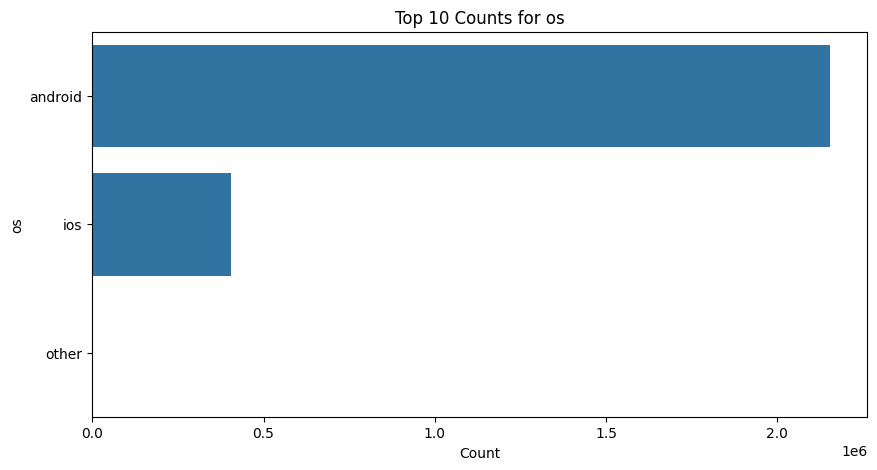

In [10]:
# --- MARKETPLACE EVENTS ---
mp_events_dir = f"{DATASET_PATH_SMALL}/marketplace/events"
mp_event_files = dataset_files.get(mp_events_dir, [])

df_mp_events = load_dataframe_from_partitions(mp_event_files, limit=DATASET_SMALL_NUM_PARTITIONS_TO_LOAD)
analyze_dataframe(df_mp_events, "Marketplace Events (Joined)")

## 5. Offers Domain Analysis
Contains `items` (static) and `events` (partitioned).

In [11]:
# --- OFFERS ITEMS ---
offers_items_path = f"{DATASET_PATH_SMALL}/offers/items.pq"
df_offers_items = load_remote_parquet(offers_items_path)
analyze_dataframe(df_offers_items, "Offers Items")

c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(



==================== ANALYZING: Offers Items ====================
Shape: (22368, 3)

1. Head (First 5 rows):


,item_id,brand_id,embedding
0,offer_1000,25974.0,"[0.01245058, -0.006554137, 0.008180908, -0.065..."
1,offer_10001,233535.0,"[0.08430327, 0.0042775664, -0.06471029, -0.089..."
2,offer_10010,237081.0,"[0.026309866, 0.07163039, 0.035467107, -0.1206..."
3,offer_10011,139056.0,"[0.04429229, 0.028968437, 0.023935385, -0.0890..."
4,offer_10019,11463.0,"[0.07399447, 0.055166934, 0.023564236, -0.0698..."



2. Info (Data Types & Non-Null Counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22368 entries, 0 to 22367
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   item_id    22368 non-null  object 
 1   brand_id   21826 non-null  float64
 2   embedding  22368 non-null  object 
dtypes: float64(1), object(2)
memory usage: 524.4+ KB

3. Describe (Statistical Summary for Numeric Columns):


,brand_id
count,21826.000000
mean,125055.585723
std,73032.772814
min,87.000000
25%,64692.000000
50%,121805.000000
75%,187727.000000
max,251377.000000



4. Missing Values (NaN Count):
item_id        0
brand_id     542
embedding      0
dtype: int64

Missing Percentages:
item_id      0.0%
brand_id     2.4%
embedding    0.0%
dtype: object

5. Duplicates Count:
  Retrying without 'embedding' column:
  0

6. Column Value Counts (Top 5 unique values for object columns):

Column: item_id
item_id
offer_9860    1
offer_9863    1
offer_9864    1
offer_9866    1
offer_9867    1
Name: count, dtype: int64
  Skipping value counts for 'embedding' column (performance optimization).

7. Visualizations:
  - Plotting distributions for numeric/timedelta columns: ['brand_id']
    Skipping distribution plot for brand_id (likely an ID with high cardinality).
  - Plotting counts for categorical columns: ['item_id', 'embedding']
    Skipping plot for item_id (too many unique values: 22368)




Loading 5 partitions (out of 227 available)...


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


Concatenating partitions...

==================== ANALYZING: Offers Events (Joined) ====================
Shape: (14814526, 4)

1. Head (First 5 rows):


,timestamp,user_id,item_id,action_type
0,1082 days 00:00:00.126754,20110833,offer_83661,seen
1,1082 days 00:00:00.143308,36541803,offer_81670,seen
2,1082 days 00:00:00.157553,34286733,offer_42637,seen
3,1082 days 00:00:00.160743,70030166,offer_787,seen
4,1082 days 00:00:00.165194,40343780,offer_32005,seen



2. Info (Data Types & Non-Null Counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14814526 entries, 0 to 14814525
Data columns (total 4 columns):
 #   Column       Dtype          
---  ------       -----          
 0   timestamp    timedelta64[us]
 1   user_id      uint64         
 2   item_id      object         
 3   action_type  object         
dtypes: object(2), timedelta64[us](1), uint64(1)
memory usage: 452.1+ MB

3. Describe (Statistical Summary for Numeric Columns):


,timestamp,user_id
count,14814526,1.481453e+07
mean,1084 days 14:36:48.473125,4.485950e+07
std,1 days 08:49:56.260556,2.598546e+07
min,1082 days 00:00:00.126754,2.800000e+01
25%,1083 days 11:11:27.227368,2.224587e+07
50%,1084 days 18:41:39.138201,4.484893e+07
75%,1085 days 15:06:51.054612,6.735857e+07
max,1086 days 23:59:59.982893,8.991868e+07



4. Missing Values (NaN Count):
timestamp      0
user_id        0
item_id        0
action_type    0
dtype: int64

Missing Percentages:
timestamp      0.0%
user_id        0.0%
item_id        0.0%
action_type    0.0%
dtype: object

5. Duplicates Count:
0

6. Column Value Counts (Top 5 unique values for object columns):

Column: item_id
item_id
offer_25160    415581
offer_54040    371172
offer_24008    293718
offer_60861    268925
offer_73859    264399
Name: count, dtype: int64

Column: action_type
action_type
seen                   14291700
offer_shown              439186
redirect_to_partner       74793
like                       8847
Name: count, dtype: int64

7. Visualizations:
  - Plotting distributions for numeric/timedelta columns: ['timestamp', 'user_id']
    Converting timestamp to total seconds for plotting.


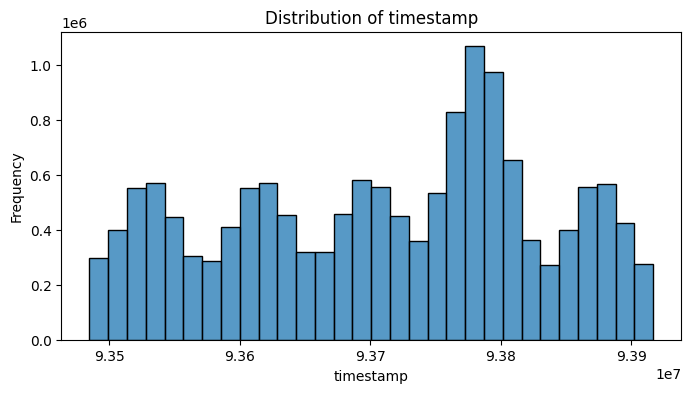

    Skipping distribution plot for user_id (likely an ID with high cardinality).
  - Plotting counts for categorical columns: ['item_id', 'action_type']
    Skipping plot for item_id (too many unique values: 2044)


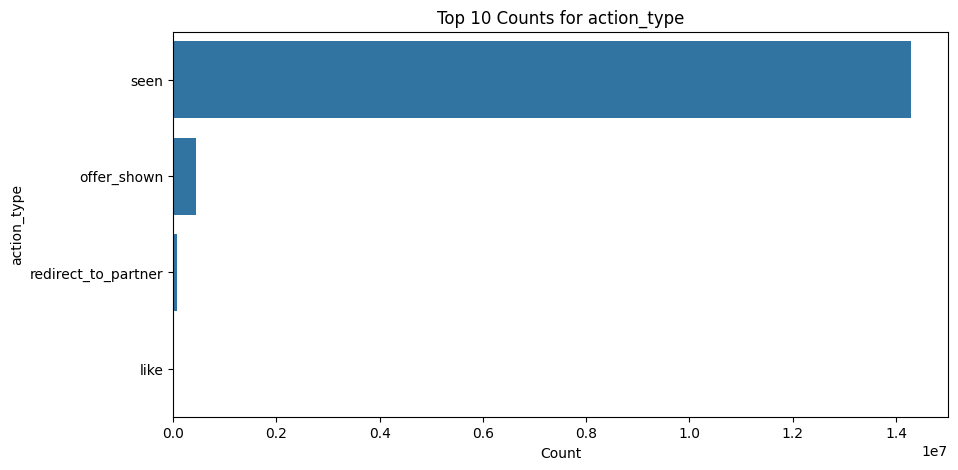

In [12]:
# --- OFFERS EVENTS ---
offers_events_dir = f"{DATASET_PATH_SMALL}/offers/events"
offers_event_files = dataset_files.get(offers_events_dir, [])

df_offers_events = load_dataframe_from_partitions(offers_event_files, limit=DATASET_SMALL_NUM_PARTITIONS_TO_LOAD)
analyze_dataframe(df_offers_events, "Offers Events (Joined)")

## 6. Reviews Domain Analysis
Reviews are partitioned by day directly in the folder.

Loading 5 partitions (out of 227 available)...


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


  Excluding columns: ['embedding']
  Reading columns: ['timestamp', 'user_id', 'brand_id', 'rating']


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


  Excluding columns: ['embedding']
  Reading columns: ['timestamp', 'user_id', 'brand_id', 'rating']


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


  Excluding columns: ['embedding']
  Reading columns: ['timestamp', 'user_id', 'brand_id', 'rating']


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


  Excluding columns: ['embedding']
  Reading columns: ['timestamp', 'user_id', 'brand_id', 'rating']


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


  Excluding columns: ['embedding']
  Reading columns: ['timestamp', 'user_id', 'brand_id', 'rating']
Concatenating partitions...

==================== ANALYZING: Reviews (Joined) ====================
Shape: (11545, 4)

1. Head (First 5 rows):


,timestamp,user_id,brand_id,rating
0,1082 days 00:01:05.711723,25741061,141226,5
1,1082 days 00:01:12.026501,71011848,65693,3
2,1082 days 00:02:15.540704,26101012,72285,5
3,1082 days 00:02:25.126055,67977146,184380,3
4,1082 days 00:02:36.993924,4055428,216938,5



2. Info (Data Types & Non-Null Counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11545 entries, 0 to 11544
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype          
---  ------     --------------  -----          
 0   timestamp  11545 non-null  timedelta64[us]
 1   user_id    11545 non-null  uint64         
 2   brand_id   11545 non-null  uint64         
 3   rating     11545 non-null  uint8          
dtypes: timedelta64[us](1), uint64(2), uint8(1)
memory usage: 282.0 KB

3. Describe (Statistical Summary for Numeric Columns):


,timestamp,user_id,brand_id,rating
count,11545,1.154500e+04,11545.000000,11545.000000
mean,1084 days 12:46:20.749131,4.602576e+07,121838.940407,4.672845
std,1 days 10:18:47.046588,2.624083e+07,72828.138532,0.842980
min,1082 days 00:01:05.711723,1.375000e+03,178.000000,1.000000
25%,1083 days 06:29:25.927125,2.306453e+07,50524.000000,5.000000
50%,1084 days 14:42:10.073106,4.665175e+07,127068.000000,5.000000
75%,1085 days 16:08:21.273703,6.866341e+07,178491.000000,5.000000
max,1086 days 23:56:36.662196,8.991487e+07,251381.000000,5.000000



4. Missing Values (NaN Count):
timestamp    0
user_id      0
brand_id     0
rating       0
dtype: int64

Missing Percentages:
timestamp    0.0%
user_id      0.0%
brand_id     0.0%
rating       0.0%
dtype: object

5. Duplicates Count:
0

6. Column Value Counts (Top 5 unique values for object columns):

7. Visualizations:
  - Plotting distributions for numeric/timedelta columns: ['timestamp', 'user_id', 'brand_id', 'rating']
    Converting timestamp to total seconds for plotting.


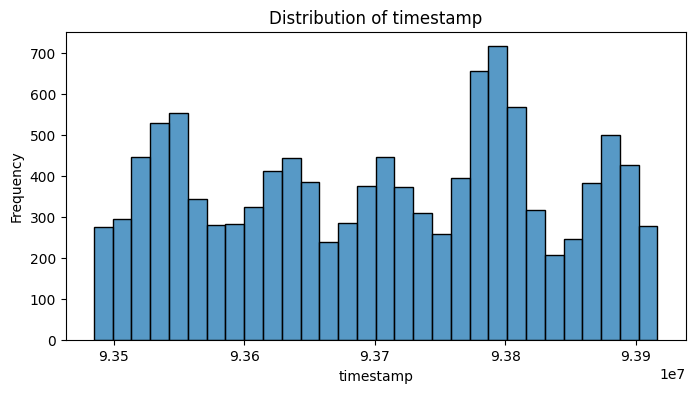

    Skipping distribution plot for user_id (likely an ID with high cardinality).
    Skipping distribution plot for brand_id (likely an ID with high cardinality).


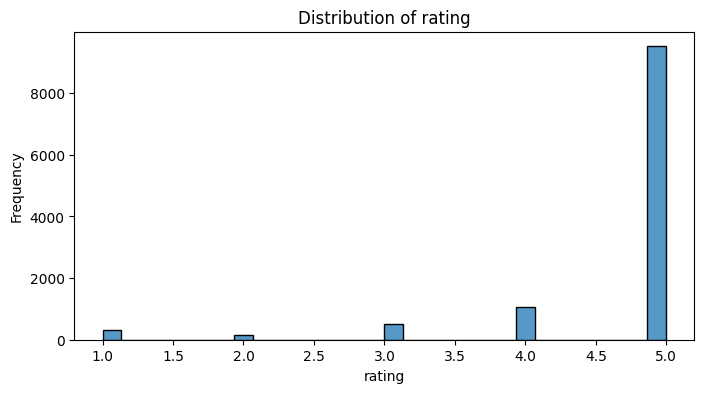

In [13]:
# --- REVIEWS ---
reviews_dir = f"{DATASET_PATH_SMALL}/reviews"
review_files = dataset_files.get(reviews_dir, [])

# Exclude embedding column to avoid schema error
df_reviews = load_dataframe_from_partitions(file_list=review_files, limit=DATASET_SMALL_NUM_PARTITIONS_TO_LOAD, columns_to_exclude=['embedding'])
analyze_dataframe(df_reviews, "Reviews (Joined)")

## 7. Payments Domain Analysis (From 'Full' Dataset)
**Note:** The `payments` data is missing from the `dataset/small` partition. 
We will load a sample from `dataset/full` to ensure we cover this domain in our analysis.

Found 1309 payment event files in FULL dataset. Loading sample...
Loading 1 partitions (out of 1309 available)...


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


Concatenating partitions...

==================== ANALYZING: Payments Events (Sample from Full) ====================
Shape: (11489064, 5)

1. Head (First 5 rows):


,timestamp,user_id,brand_id,price,transaction_hash
0,0 days,311,59566.0,-3.775189,44274ff3db5bf905
1,0 days,385,NaN,0.871653,f70452cbcdc00bd1
2,0 days,608,NaN,-2.560902,a61ff60f6e4853bf
3,0 days,1279,210055.0,-6.259911,bdaacc62ddf3f256
4,0 days,1706,NaN,-1.534527,b0d02f4a7db3f717



2. Info (Data Types & Non-Null Counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11489064 entries, 0 to 11489063
Data columns (total 5 columns):
 #   Column            Dtype          
---  ------            -----          
 0   timestamp         timedelta64[us]
 1   user_id           uint64         
 2   brand_id          float64        
 3   price             float64        
 4   transaction_hash  object         
dtypes: float64(2), object(1), timedelta64[us](1), uint64(1)
memory usage: 438.3+ MB

3. Describe (Statistical Summary for Numeric Columns):


,timestamp,user_id,brand_id,price
count,11489064,1.148906e+07,4.905857e+06,1.148860e+07
mean,0 days 14:16:03.189007,4.496241e+07,1.182331e+05,-2.785238e+00
std,0 days 06:18:18.420123,2.596263e+07,6.685465e+04,2.479296e+00
min,0 days 00:00:00,9.000000e+00,3.450000e+02,-1.000000e+01
25%,0 days 10:17:26.412480,2.246764e+07,5.956600e+04,-4.501041e+00
50%,0 days 15:23:31.012662,4.496676e+07,1.111920e+05,-2.804544e+00
75%,0 days 19:12:30.397004,6.745899e+07,1.663140e+05,-1.436162e+00
max,0 days 23:59:59.990584,8.991867e+07,2.511090e+05,1.000000e+01



4. Missing Values (NaN Count):
timestamp                 0
user_id                   0
brand_id            6583207
price                   462
transaction_hash          0
dtype: int64

Missing Percentages:
timestamp            0.0%
user_id              0.0%
brand_id            57.3%
price                0.0%
transaction_hash     0.0%
dtype: object

5. Duplicates Count:
0

6. Column Value Counts (Top 5 unique values for object columns):

Column: transaction_hash
transaction_hash
c6cc3af2bed705ec    10
5dadda0e0f9749c2     9
9237f60c040bcb86     9
0c28970442f205c4     9
b6c3be97e378435b     9
Name: count, dtype: int64

7. Visualizations:
  - Plotting distributions for numeric/timedelta columns: ['timestamp', 'user_id', 'brand_id', 'price']
    Converting timestamp to total seconds for plotting.


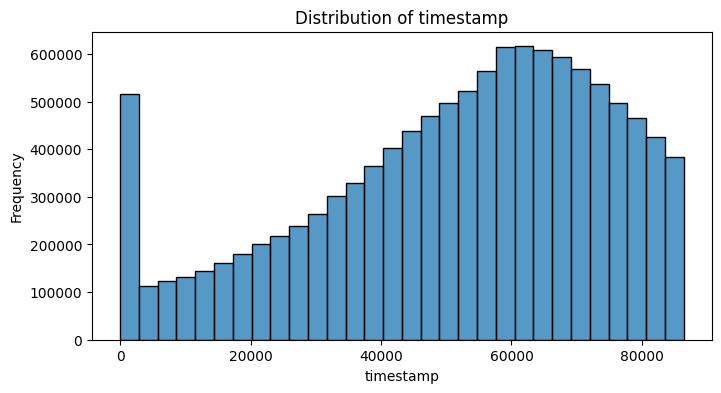

    Skipping distribution plot for user_id (likely an ID with high cardinality).
    Skipping distribution plot for brand_id (likely an ID with high cardinality).


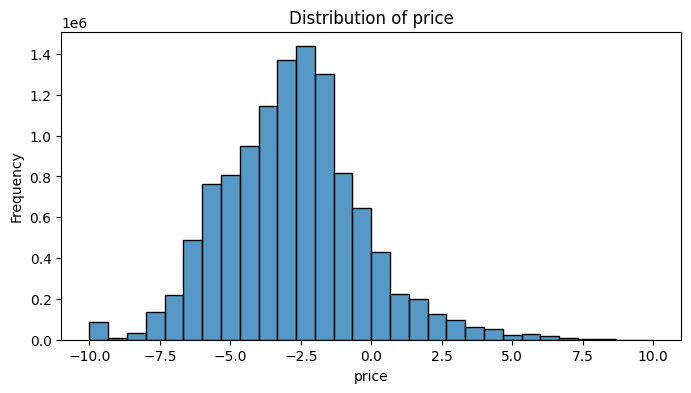

  - Plotting counts for categorical columns: ['transaction_hash']
    Skipping plot for transaction_hash (too many unique values: 9364668)




In [14]:
# --- PAYMENTS EVENTS ---
pay_events_dir = f"{DATASET_PATH_FULL}/payments/events"
pay_event_files = dataset_files.get(pay_events_dir, [])

print(f"Found {len(pay_event_files)} payment event files in FULL dataset. Loading sample...")
df_pay_events = load_dataframe_from_partitions(pay_event_files, limit=DATASET_FULL_NUM_PARTITIONS_TO_LOAD)
analyze_dataframe(df_pay_events, "Payments Events (Sample from Full)")

Found 1017 payment receipt files in FULL dataset. Loading sample...
Loading 1 partitions (out of 1017 available)...


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


Concatenating partitions...

==================== ANALYZING: Payments Receipts (Sample from Full) ====================
Shape: (1110501, 7)

1. Head (First 5 rows):


,timestamp,user_id,brand_id,approximate_item_id,count,price,transaction_hash
0,292 days 00:00:07.438252,65695573,NaN,fmcg_903525,1.0,-4.374821,45b52121842e11b4
1,292 days 00:00:07.438252,80131722,NaN,nfmcg_2093483,1.0,-4.003409,16d133993e007001
2,292 days 00:00:10.626417,38136590,NaN,fmcg_501328,1.0,-5.030706,a4084b5773be81b0
3,292 days 00:00:14.432571,51868171,NaN,fmcg_1050785,20.1,-5.248770,a663bb3a5b25bf51
4,292 days 00:00:32.906928,6274711,NaN,nfmcg_17546877,1.0,-4.907919,9df8cdba7a9745e4



2. Info (Data Types & Non-Null Counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1110501 entries, 0 to 1110500
Data columns (total 7 columns):
 #   Column               Non-Null Count    Dtype          
---  ------               --------------    -----          
 0   timestamp            1110501 non-null  timedelta64[us]
 1   user_id              1110501 non-null  uint64         
 2   brand_id             110573 non-null   float64        
 3   approximate_item_id  1110501 non-null  object         
 4   count                1110501 non-null  float64        
 5   price                1095609 non-null  float64        
 6   transaction_hash     1110501 non-null  object         
dtypes: float64(3), object(2), timedelta64[us](1), uint64(1)
memory usage: 59.3+ MB

3. Describe (Statistical Summary for Numeric Columns):


,timestamp,user_id,brand_id,count,price
count,1110501,1.110501e+06,110573.000000,1.110501e+06,1.095609e+06
mean,292 days 15:20:33.566002,4.502470e+07,139013.479285,2.165275e+00,-4.463207e+00
std,0 days 04:44:46.840899,2.593629e+07,63768.509485,1.102836e+01,1.462553e+00
min,292 days 00:00:07.438252,6.710000e+02,15.000000,4.500000e-04,-1.000000e+01
25%,292 days 12:06:02.731517,2.262796e+07,86084.000000,1.000000e+00,-5.359436e+00
50%,292 days 15:38:12.609774,4.506534e+07,165391.000000,1.000000e+00,-4.680929e+00
75%,292 days 18:57:31.296037,6.749502e+07,173820.000000,1.000000e+00,-3.699987e+00
max,292 days 23:59:59.876106,8.991836e+07,251322.000000,2.600000e+03,6.264111e+00



4. Missing Values (NaN Count):
timestamp                   0
user_id                     0
brand_id               999928
approximate_item_id         0
count                       0
price                   14892
transaction_hash            0
dtype: int64

Missing Percentages:
timestamp               0.0%
user_id                 0.0%
brand_id               90.0%
approximate_item_id     0.0%
count                   0.0%
price                   1.3%
transaction_hash        0.0%
dtype: object

5. Duplicates Count:
0

6. Column Value Counts (Top 5 unique values for object columns):

Column: approximate_item_id
approximate_item_id
nfmcg_3707423    18634
fmcg_1088547     13976
fmcg_254806      12733
fmcg_461040      10345
nfmcg_5930828    10137
Name: count, dtype: int64

Column: transaction_hash
transaction_hash
55cc577396e77d0e    1307
38715dfcb23dae6b     145
8764e6f7784c460c      94
e532c0a1d0987723      81
d2afb08814041ac3      77
Name: count, dtype: int64

7. Visualizations:
  - Plotting

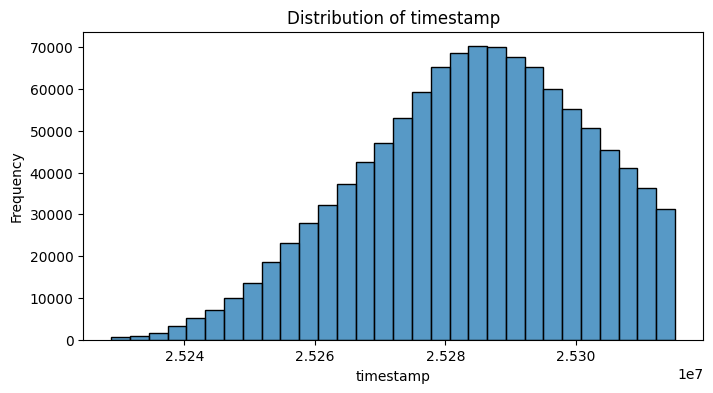

    Skipping distribution plot for user_id (likely an ID with high cardinality).
    Skipping distribution plot for brand_id (likely an ID with high cardinality).


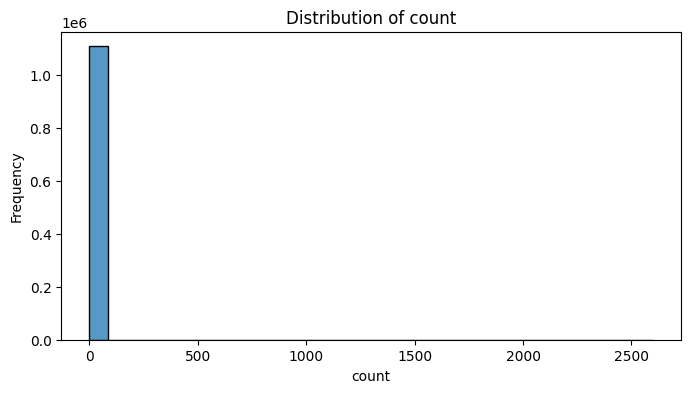

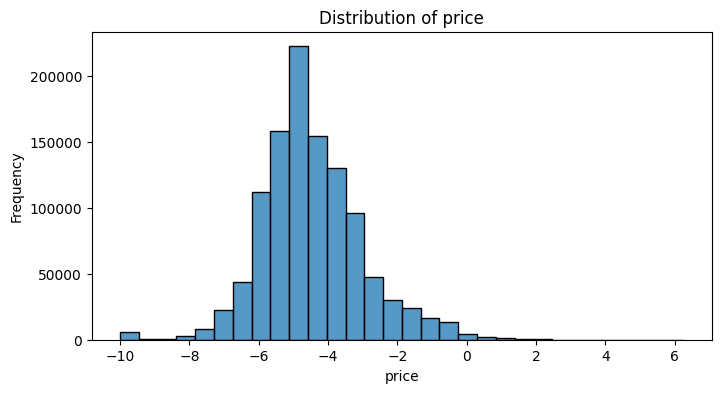

  - Plotting counts for categorical columns: ['approximate_item_id', 'transaction_hash']
    Skipping plot for approximate_item_id (too many unique values: 77009)
    Skipping plot for transaction_hash (too many unique values: 348754)




In [15]:
# --- PAYMENTS RECEIPTS ---
pay_receipts_dir = f"{DATASET_PATH_FULL}/payments/receipts"
pay_receipts_files = dataset_files.get(pay_receipts_dir, [])

print(f"Found {len(pay_receipts_files)} payment receipt files in FULL dataset. Loading sample...")
df_pay_receipts = load_dataframe_from_partitions(pay_receipts_files, limit=DATASET_FULL_NUM_PARTITIONS_TO_LOAD)
analyze_dataframe(df_pay_receipts, "Payments Receipts (Sample from Full)")